In [133]:
!pip install holidays

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [267]:
import os
import numpy as np
import pandas as pd
import datetime
import itertools
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from datetime import timedelta
import holidays
from statsmodels.formula.api import ols

In [135]:
df_si = pd.read_csv('result_si.csv')
df_si.columns = [col.lower() for col in df_si.columns]
df_si.head()

,week_start_date,week_end_date,rog_id,total_item_qty
0,2019-12-29,2020-01-04,AJWL,402200
1,2020-01-05,2020-01-11,AJWL,1080324
2,2020-01-12,2020-01-18,AJWL,844952
3,2020-01-19,2020-01-25,AJWL,721792
4,2020-01-26,2020-02-01,AJWL,756220


In [136]:
orig_df_si = df_si.copy()

In [137]:
df_si.drop(columns=['rog_id', 'week_start_date'], axis = 1, inplace = True)
df_si.head()

,week_end_date,total_item_qty
0,2020-01-04,402200
1,2020-01-11,1080324
2,2020-01-18,844952
3,2020-01-25,721792
4,2020-02-01,756220


In [138]:
df_si.set_index('week_end_date',inplace = True)
df_si = df_si.set_index(pd.DatetimeIndex(df_si.index, freq = 'W-SAT'))
df_si.head()

,total_item_qty
week_end_date,
2020-01-04,402200
2020-01-11,1080324
2020-01-18,844952
2020-01-25,721792
2020-02-01,756220


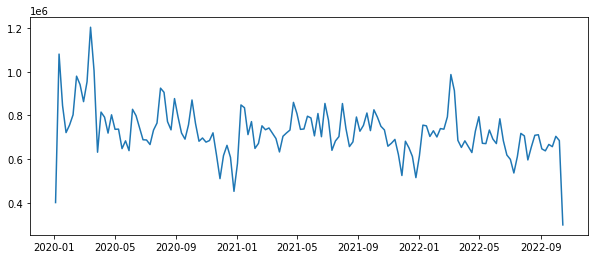

In [139]:
plt.figure(figsize=(10,4))
plt.plot(df_si)

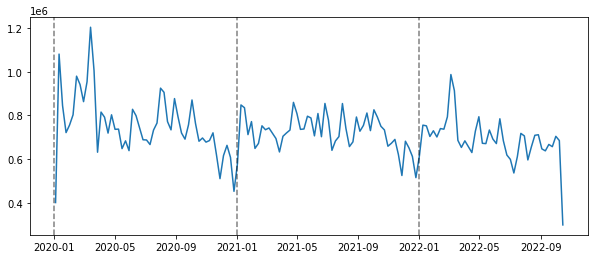

In [140]:
plt.figure(figsize=(10,4))
plt.plot(df_si)
for year in range(2020,2023):
    plt.axvline(datetime.datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

In [141]:
stl = STL(df_si)
result = stl.fit()

In [142]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

In [143]:
seasonal_df = pd.DataFrame(seasonal)
trend_df = pd.DataFrame(trend)
resid_df = pd.DataFrame(resid)

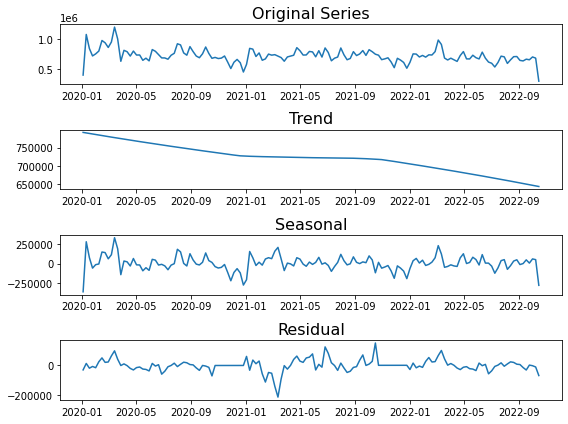

In [144]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(df_si)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

In [145]:
class holiday:
    """
    This class lists both Federal and State holidays for current year 
    and next 9 years.
    """
    def __init__(self):
        """
        This initialization method obtains current year and lists all USA states.
        """
        self.current_year = date.today().year
        self.states_list = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 
                             'CO', 'CT', 'DC', 'DE', 'FL', 
                             'GA', 'HI', 'IA', 'ID', 'IL', 
                             'IN', 'KS', 'KY', 'LA', 'MA', 
                             'MD', 'ME', 'MI', 'MN', 'MO', 
                             'MS', 'MT', 'NC', 'ND', 'NE', 
                             'NH', 'NJ', 'NM', 'NV', 'NY', 
                             'OH', 'OK', 'OR', 'PA', 'RI', 
                             'SC', 'SD', 'TN', 'TX', 'UT', 
                             'VA', 'VT', 'WA', 'WI', 'WV', 'WY'
                            ]
        self.holiday_date_list = []
        self.holiday_details_list = []
        self.df_holiday = pd.DataFrame()
    
    def collect_federal_holiday_list(self):
        """
        This method lists all federal holidays along with observed ones
        in USA in a given year.
        """
        for year in range(self.current_year-3, self.current_year + 11):
            # Print all the holidays in United States in the year 
            for federal_holiday_val in holidays.UnitedStates(years = year, observed = True).items():
                print(f"Federal Holiday :: {str(federal_holiday_val[0])} :: {federal_holiday_val[1]}")
                self.holiday_date_list.append(federal_holiday_val[0])
                self.holiday_details_list.append(('FE', 
                                                  year, 
                                                  str(federal_holiday_val[0]), 
                                                  federal_holiday_val[1]
                                                 )
                                                )

    def collect_state_holiday_list(self):
        """
        This method lists all state holidays along with observed ones
        in USA in a given year which are not federal holidays.
        """
        for year in range(self.current_year-3, self.current_year + 11):
            for state in self.states_list:
                for state_holiday_val in holidays.UnitedStates(years = year, observed = True, subdiv = state).items():
                    if state_holiday_val[0] not in self.holiday_date_list:
                        print(f"State {state} Holiday :: {str(state_holiday_val[0])} :: {state_holiday_val[1]}")
                        self.holiday_date_list.append(state_holiday_val[0])
                        self.holiday_details_list.append((state, 
                                                          year, 
                                                          str(state_holiday_val[0]), 
                                                          state_holiday_val[1]
                                                          )
                                                        )
    
    def get_holiday(self, year):
        """
        This method provides the list of federal and state holidays 
        in a given year. It also writes the data in a csv file with name format 
        as holiday_list_<<4 digit year, comes from input parameter>>.csv.
        """
        yearly_holiday_list = []
        print(f"List of holidays in {year}:-")
        #print(self.holiday_details_list)
        for holiday_val in self.holiday_details_list:
            if holiday_val[1] == year:
                print(f"{holiday_val[0]} :: {holiday_val[1]} :: {holiday_val[2]} :: {holiday_val[3]}")
                yearly_holiday_list.append(holiday_val)
        self.df_holiday = pd.DataFrame(yearly_holiday_list, columns =['level', 'year', 'date', 'holiday_name'])
        #print(self.df_holiday)
        self.df_holiday.to_csv('holiday_list_' + str(year) + '.csv', index = False)
    
    def __repr__(self):
        """
        This method prints states list and current year.
        """
        print(f"Current Year : {self.current_year}")
        print(f"State List : {self.states_list}")

    def __str__(self):
        """
        This method prints states list and current year.
        """
        print(f"Current Year : {self.current_year}")
        print(f"State List : {self.states_list}") 

current_year = date.today().year
hdy = holiday()
help(holiday)
hdy.collect_federal_holiday_list()
hdy.collect_state_holiday_list()

Help on class holiday in module __main__:

class holiday(builtins.object)
 |  This class lists both Federal and State holidays for current year 
 |  and next 9 years.
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      This initialization method obtains current year and lists all USA states.
 |  
 |  __repr__(self)
 |      This method prints states list and current year.
 |  
 |  __str__(self)
 |      This method prints states list and current year.
 |  
 |  collect_federal_holiday_list(self)
 |      This method lists all federal holidays along with observed ones
 |      in USA in a given year.
 |  
 |  collect_state_holiday_list(self)
 |      This method lists all state holidays along with observed ones
 |      in USA in a given year which are not federal holidays.
 |  
 |  get_holiday(self, year)
 |      This method provides the list of federal and state holidays 
 |      in a given year. It also writes the data in a csv file with name format 
 |      as holiday_list_<<4 d

In [146]:
current_year_hdy = hdy.get_holiday(current_year)
one_year_ago_year_hdy = hdy.get_holiday(current_year-1)
two_year_ago_year_hdy = hdy.get_holiday(current_year-2)
three_year_ago_year_hdy = hdy.get_holiday(current_year-3)

List of holidays in 2022:-
FE :: 2022 :: 2022-01-01 :: New Year's Day
FE :: 2022 :: 2022-01-17 :: Martin Luther King Jr. Day
FE :: 2022 :: 2022-02-21 :: Washington's Birthday
FE :: 2022 :: 2022-05-30 :: Memorial Day
FE :: 2022 :: 2022-06-19 :: Juneteenth National Independence Day
FE :: 2022 :: 2022-06-20 :: Juneteenth National Independence Day (Observed)
FE :: 2022 :: 2022-07-04 :: Independence Day
FE :: 2022 :: 2022-09-05 :: Labor Day
FE :: 2022 :: 2022-10-10 :: Columbus Day
FE :: 2022 :: 2022-11-11 :: Veterans Day
FE :: 2022 :: 2022-11-24 :: Thanksgiving
FE :: 2022 :: 2022-12-25 :: Christmas Day
FE :: 2022 :: 2022-12-26 :: Christmas Day (Observed)
AK :: 2022 :: 2022-03-28 :: Seward's Day
AK :: 2022 :: 2022-10-18 :: Alaska Day
AL :: 2022 :: 2022-04-25 :: Confederate Memorial Day
AL :: 2022 :: 2022-06-06 :: Jefferson Davis Birthday
CA :: 2022 :: 2022-02-15 :: Susan B. Anthony Day
CA :: 2022 :: 2022-03-31 :: César Chávez Day
CA :: 2022 :: 2022-11-25 :: Day After Thanksgiving
CT :: 2022 

In [147]:
!ls -ltr holiday_list_*.csv

-rw-r--r-- 1 root root 2063 Oct 12 14:18 holiday_list_2022.csv
-rw-r--r-- 1 root root 1995 Oct 12 14:18 holiday_list_2021.csv
-rw-r--r-- 1 root root 1854 Oct 12 14:18 holiday_list_2020.csv
-rw-r--r-- 1 root root 1723 Oct 12 14:18 holiday_list_2019.csv


In [148]:
!cut -d "," -f 1,3 holiday_list_*.csv|grep -v "level,date"|grep "FE"|cut -d"," -f2 > holiday_dates.csv
!sort holiday_dates.csv

2019-01-01
2019-01-21
2019-02-18
2019-05-27
2019-07-04
2019-09-02
2019-10-14
2019-11-11
2019-11-28
2019-12-25
2020-01-01
2020-01-20
2020-02-17
2020-05-25
2020-07-03
2020-07-04
2020-09-07
2020-10-12
2020-11-11
2020-11-26
2020-12-25
2021-01-01
2021-01-18
2021-02-15
2021-05-31
2021-06-18
2021-06-19
2021-07-04
2021-07-05
2021-09-06
2021-10-11
2021-11-11
2021-11-25
2021-12-24
2021-12-25
2021-12-31
2022-01-01
2022-01-17
2022-02-21
2022-05-30
2022-06-19
2022-06-20
2022-07-04
2022-09-05
2022-10-10
2022-11-11
2022-11-24
2022-12-25
2022-12-26


In [149]:
df_holiday = pd.read_csv('holiday_dates.csv', header = None)
df_holiday.columns = ['holiday_date']
df_holiday.head()

,holiday_date
0,2019-01-01
1,2019-01-21
2,2019-02-18
3,2019-05-27
4,2019-07-04


In [235]:
sdate = datetime.datetime.strptime('2020-01-04', '%Y-%m-%d')
edate = datetime.datetime.strptime('2023-01-01', '%Y-%m-%d')
df_dates = pd.DataFrame([sdate + timedelta(days=x) for x in range((edate - sdate).days)])
df_dates.columns = ['date_val']
df_dates['day_of_the_week'] = df_dates['date_val'].apply(lambda x: x.strftime('%a'))
df_dates['day_of_the_week_id'] = df_dates['date_val'].apply(lambda x: x.isoweekday())
df_dates.date_val = df_dates['date_val'].apply(lambda x : datetime.datetime.strftime(x, '%Y-%m-%d'))
df_dates['week_end_date'] = np.where(df_dates['day_of_the_week_id']==6, df_dates['date_val'],np.nan)
df_dates['week_end_date'] = df_dates['week_end_date'].fillna(method = 'bfill')
df_dates['week_start_date'] = np.where(df_dates['date_val']=='2020-01-04', '2019-12-29',np.nan)
df_dates['week_start_date'] = np.where(df_dates['day_of_the_week_id']==7, df_dates['date_val'],np.nan)
df_dates['week_start_date'] = df_dates['week_start_date'].fillna(method = 'ffill')
df_dates.fillna('2019-12-29', inplace = True)
df_dates = df_dates[['date_val', 'day_of_the_week', 'day_of_the_week_id', 'week_start_date', 'week_end_date']]
df_dates.head(14)

,date_val,day_of_the_week,day_of_the_week_id,week_start_date,week_end_date
0,2020-01-04,Sat,6,2019-12-29,2020-01-04
1,2020-01-05,Sun,7,2020-01-05,2020-01-11
2,2020-01-06,Mon,1,2020-01-05,2020-01-11
3,2020-01-07,Tue,2,2020-01-05,2020-01-11
4,2020-01-08,Wed,3,2020-01-05,2020-01-11
5,2020-01-09,Thu,4,2020-01-05,2020-01-11
6,2020-01-10,Fri,5,2020-01-05,2020-01-11
7,2020-01-11,Sat,6,2020-01-05,2020-01-11
8,2020-01-12,Sun,7,2020-01-12,2020-01-18
9,2020-01-13,Mon,1,2020-01-12,2020-01-18


In [244]:
df_date_holiday_combined = pd.merge(df_dates, df_holiday, how = 'left', left_on='date_val', right_on='holiday_date')
df_date_holiday_combined['holiday_included_flag'] = np.where((df_date_holiday_combined['holiday_date'] >= df_date_holiday_combined['week_start_date']) & (df_date_holiday_combined['holiday_date'] <= df_date_holiday_combined['week_end_date']), 1, 0)
df_date_holiday_combined.head(30)

,date_val,day_of_the_week,day_of_the_week_id,week_start_date,week_end_date,holiday_date,holiday_included_flag
0,2020-01-04,Sat,6,2019-12-29,2020-01-04,NaN,0
1,2020-01-05,Sun,7,2020-01-05,2020-01-11,NaN,0
2,2020-01-06,Mon,1,2020-01-05,2020-01-11,NaN,0
3,2020-01-07,Tue,2,2020-01-05,2020-01-11,NaN,0
4,2020-01-08,Wed,3,2020-01-05,2020-01-11,NaN,0
5,2020-01-09,Thu,4,2020-01-05,2020-01-11,NaN,0
6,2020-01-10,Fri,5,2020-01-05,2020-01-11,NaN,0
7,2020-01-11,Sat,6,2020-01-05,2020-01-11,NaN,0
8,2020-01-12,Sun,7,2020-01-12,2020-01-18,NaN,0
9,2020-01-13,Mon,1,2020-01-12,2020-01-18,NaN,0


In [252]:
df_week_holiday_combined = df_date_holiday_combined[['week_end_date', 'holiday_included_flag']].drop_duplicates()
df_week_holiday_combined.set_index('week_end_date', inplace = True)
df_week_holiday_combined

,holiday_included_flag
week_end_date,
2020-01-04,0
2020-01-11,0
2020-01-18,0
2020-01-25,0
2020-01-25,1
...,...
2022-12-10,0
2022-12-17,0
2022-12-24,0


In [175]:
df = pd.read_csv('result_618855.csv')
df.columns = [col.lower() for col in df.columns]
pd.set_option('display.float_format', lambda x: '%.2f' % x)
orig_df = df.copy()
df.head()

,total_amt/total_item_qty,.95 * reg_unit_prc,consumer_selling_cd,rog_id,week_start_date,week_end_date,total_item_qty,total_amt,reg_unit_prc,promo_unit_prc,promo_ind
0,4.28,5.50,618855,AJWL,2019-12-29,2020-01-04,664,2838.88,5.79,4.99,1
1,4.79,5.50,618855,AJWL,2020-01-05,2020-01-11,1334,6392.02,5.79,NaN,0
2,5.78,5.50,618855,AJWL,2020-01-12,2020-01-18,892,5158.42,5.79,NaN,0
3,5.79,5.50,618855,AJWL,2020-01-19,2020-01-25,1039,6020.05,5.79,NaN,0
4,5.78,5.50,618855,AJWL,2020-01-26,2020-02-01,1141,6597.61,5.79,NaN,0


In [176]:
df.columns = ['actual_avg_prc', '95_pct_of_reg_unit_prc',
       'consumer_selling_cd', 'rog_id', 'week_start_date', 'week_end_date',
       'total_item_qty', 'total_amt', 'reg_unit_prc', 'promo_unit_prc',
       'promo_ind']

In [177]:
df.drop(columns = ['rog_id', 'week_start_date'], axis = 1, inplace = True)
df = df.fillna(0)
df.head()

,actual_avg_prc,95_pct_of_reg_unit_prc,consumer_selling_cd,week_end_date,total_item_qty,total_amt,reg_unit_prc,promo_unit_prc,promo_ind
0,4.28,5.50,618855,2020-01-04,664,2838.88,5.79,4.99,1
1,4.79,5.50,618855,2020-01-11,1334,6392.02,5.79,0.00,0
2,5.78,5.50,618855,2020-01-18,892,5158.42,5.79,0.00,0
3,5.79,5.50,618855,2020-01-25,1039,6020.05,5.79,0.00,0
4,5.78,5.50,618855,2020-02-01,1141,6597.61,5.79,0.00,0


In [178]:
df.set_index('week_end_date', inplace = True)
df.head()

,actual_avg_prc,95_pct_of_reg_unit_prc,consumer_selling_cd,total_item_qty,total_amt,reg_unit_prc,promo_unit_prc,promo_ind
week_end_date,,,,,,,,
2020-01-04,4.28,5.50,618855,664,2838.88,5.79,4.99,1
2020-01-11,4.79,5.50,618855,1334,6392.02,5.79,0.00,0
2020-01-18,5.78,5.50,618855,892,5158.42,5.79,0.00,0
2020-01-25,5.79,5.50,618855,1039,6020.05,5.79,0.00,0
2020-02-01,5.78,5.50,618855,1141,6597.61,5.79,0.00,0


In [179]:
df['ln_total_item_qty'] = np.log(df['total_item_qty'])
df['ln_actual_avg_prc'] = np.log(df['actual_avg_prc'])
df['ln_reg_unit_prc'] = np.log(df['reg_unit_prc'])
df['ln_promo_unit_prc'] = np.log(df['promo_unit_prc'])
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,actual_avg_prc,95_pct_of_reg_unit_prc,consumer_selling_cd,total_item_qty,total_amt,reg_unit_prc,promo_unit_prc,promo_ind,ln_total_item_qty,ln_actual_avg_prc,ln_reg_unit_prc,ln_promo_unit_prc
week_end_date,,,,,,,,,,,,
2020-01-04,4.28,5.50,618855,664,2838.88,5.79,4.99,1,6.50,1.45,1.76,1.61
2020-01-11,4.79,5.50,618855,1334,6392.02,5.79,0.00,0,7.20,1.57,1.76,-inf
2020-01-18,5.78,5.50,618855,892,5158.42,5.79,0.00,0,6.79,1.75,1.76,-inf
2020-01-25,5.79,5.50,618855,1039,6020.05,5.79,0.00,0,6.95,1.76,1.76,-inf
2020-02-01,5.78,5.50,618855,1141,6597.61,5.79,0.00,0,7.04,1.75,1.76,-inf


In [181]:
df['eff_unit_price'] = np.where(df['promo_ind']==1, df['promo_unit_prc'], df['reg_unit_prc'])
df.head()

,actual_avg_prc,95_pct_of_reg_unit_prc,consumer_selling_cd,total_item_qty,total_amt,reg_unit_prc,promo_unit_prc,promo_ind,ln_total_item_qty,ln_actual_avg_prc,ln_reg_unit_prc,ln_promo_unit_prc,eff_unit_price
week_end_date,,,,,,,,,,,,,
2020-01-04,4.28,5.50,618855,664,2838.88,5.79,4.99,1,6.50,1.45,1.76,1.61,4.99
2020-01-11,4.79,5.50,618855,1334,6392.02,5.79,0.00,0,7.20,1.57,1.76,-inf,5.79
2020-01-18,5.78,5.50,618855,892,5158.42,5.79,0.00,0,6.79,1.75,1.76,-inf,5.79
2020-01-25,5.79,5.50,618855,1039,6020.05,5.79,0.00,0,6.95,1.76,1.76,-inf,5.79
2020-02-01,5.78,5.50,618855,1141,6597.61,5.79,0.00,0,7.04,1.75,1.76,-inf,5.79


In [182]:
base_qty_list = []
qty_list = df[['promo_ind', 'total_item_qty']].values.tolist()
for idx, e in enumerate(qty_list):
    '''
    if idx > 30:
        break
    '''
    #print('idx', idx)
    if e[0] == 1:
        if idx == 0:
            #print("i am here")
            base_qty_list.append(e[1])
        else:
            srch_idx = idx - 1
            total_non_promo_wk_qty_val = 0
            non_promo_week_ctr = 0
            ctr = 0
            while non_promo_week_ctr < 8 and srch_idx >= 0:
                #print("non_promo_week_ctr: ", non_promo_week_ctr)
                #print("srch_idx: ", srch_idx)
                if qty_list[srch_idx][0] == 0:
                    #print("qty ",qty_list[srch_idx][1])
                    non_promo_week_ctr += 1
                    total_non_promo_wk_qty_val += qty_list[srch_idx][1]
                    #print(qty_list[srch_idx][1])
                srch_idx -= 1
            #print(total_non_promo_wk_qty_val , non_promo_week_ctr)
            base_qty = total_non_promo_wk_qty_val / non_promo_week_ctr
            base_qty_list.append(base_qty)
    elif e[0] == 0:
        #print("i came here too")
        base_qty_list.append(e[1])
list(zip(qty_list, base_qty_list))

[([1, 664], 664),
 ([0, 1334], 1334),
 ([0, 892], 892),
 ([0, 1039], 1039),
 ([0, 1141], 1141),
 ([0, 1023], 1023),
 ([0, 1083], 1083),
 ([0, 1033], 1033),
 ([0, 1096], 1096),
 ([0, 1096], 1096),
 ([0, 1565], 1565),
 ([0, 1662], 1662),
 ([0, 1017], 1017),
 ([0, 1177], 1177),
 ([0, 1064], 1064),
 ([0, 1352], 1352),
 ([0, 1380], 1380),
 ([0, 1345], 1345),
 ([1, 1447], 1320.25),
 ([1, 1379], 1320.25),
 ([1, 1454], 1320.25),
 ([1, 1556], 1320.25),
 ([1, 1887], 1320.25),
 ([1, 1664], 1320.25),
 ([1, 1619], 1320.25),
 ([1, 1472], 1320.25),
 ([0, 1373], 1373),
 ([0, 1289], 1289),
 ([0, 1195], 1195),
 ([0, 1129], 1129),
 ([0, 1219], 1219),
 ([0, 1236], 1236),
 ([1, 1588], 1270.75),
 ([0, 1409], 1409),
 ([0, 1268], 1268),
 ([0, 1237], 1237),
 ([0, 1216], 1216),
 ([0, 1093], 1093),
 ([0, 1159], 1159),
 ([0, 1121], 1121),
 ([0, 1092], 1092),
 ([0, 1195], 1195),
 ([0, 998], 998),
 ([0, 955], 955),
 ([0, 1006], 1006),
 ([0, 1102], 1102),
 ([0, 1037], 1037),
 ([0, 842], 842),
 ([0, 1088], 1088),
 ([

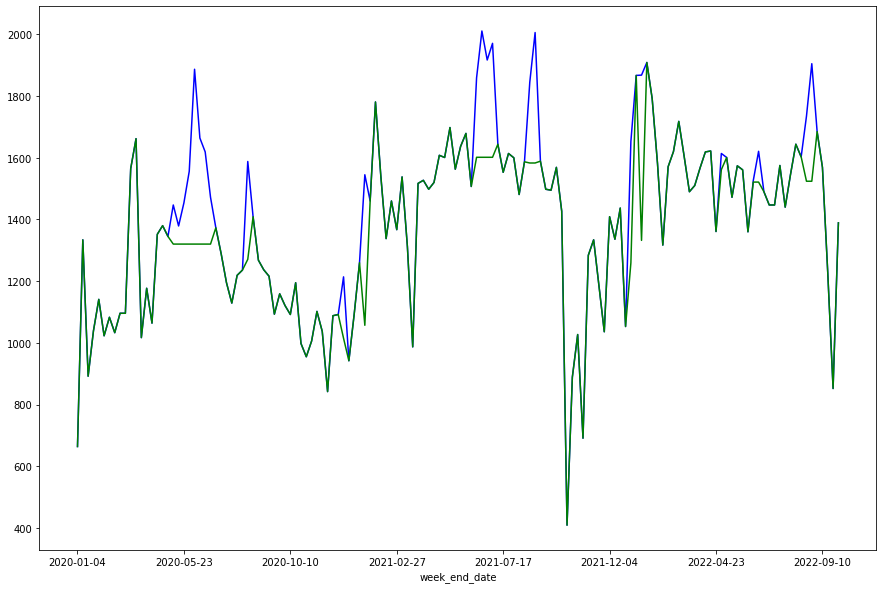

In [183]:
df['base_qty'] = base_qty_list
plt.figure(figsize = (15, 10))
df['total_item_qty'].plot(color = 'blue')
df['base_qty'].plot(color = 'green')
df['lift_qty'] = df['total_item_qty'] - df['base_qty']

In [184]:
trend_df

,trend
week_end_date,
2020-01-04,790963.16
2020-01-11,789517.86
2020-01-18,788078.53
2020-01-25,786645.46
2020-02-01,785218.98
...,...
2022-09-17,650817.06
2022-09-24,649196.74
2022-10-01,647569.80


In [264]:
df_1 = pd.merge(df.reset_index(), trend_df.reset_index(), left_index = True,  right_index = True)
df_1.drop(columns = ['week_end_date_y'], axis = 1, inplace = True)
df_1.rename(columns = {'week_end_date_x' : 'week_end_date'}, inplace = True)
df_1.set_index('week_end_date', inplace = True)

df_2 = pd.merge(df_1.reset_index(), seasonal_df.reset_index(), left_index = True,  right_index = True)
df_2.drop(columns = ['week_end_date_y'], axis = 1, inplace = True)
df_2.rename(columns = {'week_end_date_x' : 'week_end_date'}, inplace = True)
df_2.set_index('week_end_date', inplace = True)

df_3 = pd.merge(df_2, df_week_holiday_combined, left_index = True, right_index = True, how = 'inner')

In [266]:
df_final = df_3

In [268]:
df_final.columns

Index(['actual_avg_prc', '95_pct_of_reg_unit_prc', 'consumer_selling_cd',
       'total_item_qty', 'total_amt', 'reg_unit_prc', 'promo_unit_prc',
       'promo_ind', 'ln_total_item_qty', 'ln_actual_avg_prc',
       'ln_reg_unit_prc', 'ln_promo_unit_prc', 'eff_unit_price', 'base_qty',
       'lift_qty', 'trend', 'season', 'holiday_included_flag'],
      dtype='object')

In [270]:
model_final_robust_1 = ols("ln_total_item_qty ~ eff_unit_price + ln_reg_unit_prc + trend + season + holiday_included_flag + base_qty", data = df_final).fit(cov_type = "HC0")
print(model_final_robust_1.summary())
print(model_final_robust_1.conf_int())

                            OLS Regression Results                            
Dep. Variable:      ln_total_item_qty   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     249.6
Date:                Wed, 12 Oct 2022   Prob (F-statistic):           9.82e-80
Time:                        15:33:34   Log-Likelihood:                 257.67
No. Observations:                 171   AIC:                            -501.3
Df Residuals:                     164   BIC:                            -479.3
Df Model:                           6                                         
Covariance Type:                  HC0                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 6.65

In [271]:
model_final_robust_2 = ols("ln_total_item_qty ~ eff_unit_price + ln_reg_unit_prc + trend + season + holiday_included_flag", data = df_final).fit(cov_type = "HC0")
print(model_final_robust_2.summary())
print(model_final_robust_2.conf_int())

                            OLS Regression Results                            
Dep. Variable:      ln_total_item_qty   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     36.53
Date:                Wed, 12 Oct 2022   Prob (F-statistic):           4.45e-25
Time:                        16:01:49   Log-Likelihood:                 47.366
No. Observations:                 171   AIC:                            -82.73
Df Residuals:                     165   BIC:                            -63.88
Df Model:                           5                                         
Covariance Type:                  HC0                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 5.24

In [272]:
model_final_robust_3 = ols("ln_total_item_qty ~ eff_unit_price + ln_reg_unit_prc + season + holiday_included_flag", data = df_final).fit(cov_type = "HC0")
print(model_final_robust_3.summary())
print(model_final_robust_3.conf_int())

                            OLS Regression Results                            
Dep. Variable:      ln_total_item_qty   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     43.39
Date:                Wed, 12 Oct 2022   Prob (F-statistic):           6.92e-25
Time:                        16:02:49   Log-Likelihood:                 45.871
No. Observations:                 171   AIC:                            -81.74
Df Residuals:                     166   BIC:                            -66.03
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 1.81

In [273]:
model_final_robust_4 = ols("ln_total_item_qty ~ eff_unit_price + ln_reg_unit_prc + season", data = df_final).fit(cov_type = "HC0")
print(model_final_robust_4.summary())
print(model_final_robust_4.conf_int())

                            OLS Regression Results                            
Dep. Variable:      ln_total_item_qty   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     57.58
Date:                Wed, 12 Oct 2022   Prob (F-statistic):           1.31e-25
Time:                        16:03:19   Log-Likelihood:                 45.749
No. Observations:                 171   AIC:                            -83.50
Df Residuals:                     167   BIC:                            -70.93
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.8227      0.537     